In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [2]:
def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [3]:
encoder = keras.layers.Dense(2, input_shape=[3])
decoder = keras.layers.Dense(3, input_shape=[2])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer="sgd")

autoencoder.fit(X_train, X_train, epochs=20)

coding = autoencoder.predict(X_train)

Epoch 1/20
2/2 [==============================] - 2s 5ms/step - loss: 0.5618
Epoch 2/20
2/2 [==============================] - 0s 4ms/step - loss: 0.5244
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.4905
Epoch 4/20
2/2 [==============================] - 0s 4ms/step - loss: 0.4586
Epoch 5/20
2/2 [==============================] - 0s 4ms/step - loss: 0.4302
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.4037
Epoch 7/20
2/2 [==============================] - 0s 4ms/step - loss: 0.3802
Epoch 8/20
2/2 [==============================] - 0s 4ms/step - loss: 0.3577
Epoch 9/20
2/2 [==============================] - 0s 4ms/step - loss: 0.3374
Epoch 10/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3185
Epoch 11/20
2/2 [==============================] - 0s 4ms/step - loss: 0.3012
Epoch 12/20
2/2 [==============================] - 0s 4ms/step - loss: 0.2853
Epoch 13/20
2/2 [==============================] - 0s 3ms/step - loss: 0.

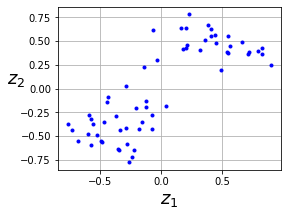

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,3))
plt.plot(coding[:,0], coding[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

In [5]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [6]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [7]:
stacked_encoder = keras.models.Sequential([ 
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])

stacked_decoder = keras.models.Sequential([ 
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28]),
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])

stacked_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3423 - rounded_accuracy: 0.8834 - val_loss: 0.3182 - val_rounded_accuracy: 0.9025
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3093 - rounded_accuracy: 0.9117 - val_loss: 0.3083 - val_rounded_accuracy: 0.9163
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3024 - rounded_accuracy: 0.9177 - val_loss: 0.3047 - val_rounded_accuracy: 0.9206
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2988 - rounded_accuracy: 0.9207 - val_loss: 0.2979 - val_rounded_accuracy: 0.9235
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2962 - rounded_accuracy: 0.9230 - val_loss: 0.2965 - val_rounded_accuracy: 0.9232
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2943 - rounded_accuracy: 0.9245 - val_loss: 0.2944 - val_rounded_accuracy: 0.9257
Epoch 7/10
1719/1719 [============

In [8]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [9]:
def show_reconstructions(model, images=X_valid, n_images=10):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

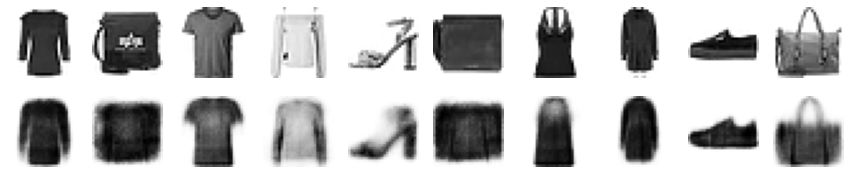

In [10]:
show_reconstructions(stacked_ae)

In [11]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

C:\Users\ozing\miniconda3\envs\handson-ml2\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\ozing\miniconda3\envs\handson-ml2\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


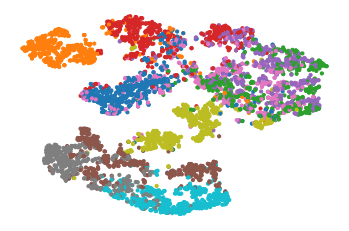

In [12]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

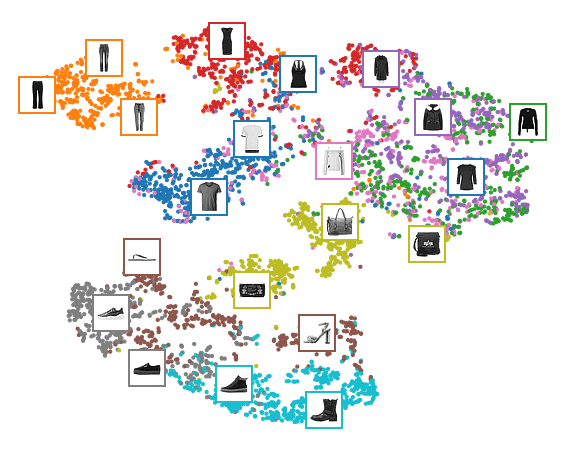

In [13]:
import matplotlib as mpl


plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

In [14]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    
    def build(self, batch_input_size):
        self.biases = self.add_weight(name="bias", initializer="zeros", shape=[self.dense.input_shape[-1]])
        super().build(batch_input_size)

    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [15]:
keras.backend.clear_session()

dense1 = keras.layers.Dense(100, activation="selu")
dense2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([ 
    keras.layers.Flatten(input_shape=[28, 28]),
    dense1,
    dense2,
])

tied_decoder = keras.models.Sequential([ 
    DenseTranspose(dense2, activation="selu"),
    DenseTranspose(dense1, activation="sigmoid"),
    keras.layers.Reshape([28, 28]),
])

tied_coder = keras.models.Sequential([tied_encoder, tied_decoder])

tied_coder.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])

tied_coder.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3267 - rounded_accuracy: 0.8960 - val_loss: 0.3122 - val_rounded_accuracy: 0.8998
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2979 - rounded_accuracy: 0.9221 - val_loss: 0.2986 - val_rounded_accuracy: 0.9256
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2917 - rounded_accuracy: 0.9276 - val_loss: 0.2935 - val_rounded_accuracy: 0.9294
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2885 - rounded_accuracy: 0.9306 - val_loss: 0.2936 - val_rounded_accuracy: 0.9204
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2864 - rounded_accuracy: 0.9324 - val_loss: 0.2873 - val_rounded_accuracy: 0.9349
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2850 - rounded_accuracy: 0.9338 - val_loss: 0.2866 - val_rounded_accuracy: 0.9310
Epoch 7/10
1719/1719 [============

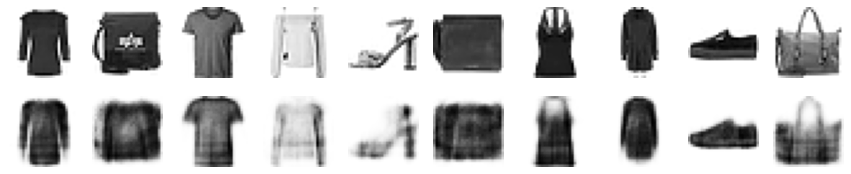

In [16]:
show_reconstructions(tied_coder)

In [17]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer, n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])

    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    
    autoencoder = keras.models.Sequential([encoder, decoder])
    
    autoencoder.compile(optimizer, loss, metrics=metrics)
    
    autoencoder.fit(X_train, X_train, epochs=n_epochs, validation_data=(X_valid, X_valid))
    
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [18]:
K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(100, X_train_flat, X_valid_flat, "binary_crossentropy", keras.optimizers.SGD(learning_rate=1.5), output_activation="sigmoid", metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(learning_rate=0.05), output_activation="selu")

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3447 - rounded_accuracy: 0.8875 - val_loss: 0.3109 - val_rounded_accuracy: 0.9168
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3025 - rounded_accuracy: 0.9218 - val_loss: 0.2992 - val_rounded_accuracy: 0.9259
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2936 - rounded_accuracy: 0.9299 - val_loss: 0.2923 - val_rounded_accuracy: 0.9330
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2881 - rounded_accuracy: 0.9352 - val_loss: 0.2879 - val_rounded_accuracy: 0.9367
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2845 - rounded_accuracy: 0.9386 - val_loss: 0.2849 - val_rounded_accuracy: 0.9398
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2820 - rounded_accuracy: 0.9411 - val_loss: 0.2827 - val_rounded_accuracy: 0.9420
Epoch 7/10
1719/1719 [==================

In [19]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1,
    enc2,
    dec2,
    dec1,
    keras.layers.Reshape([28, 28]),
])

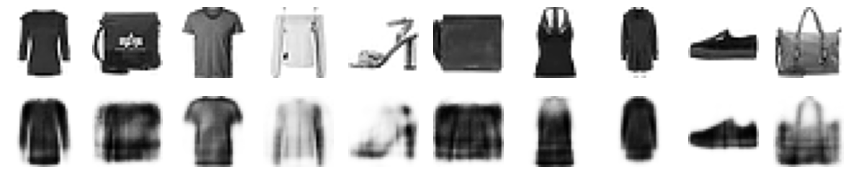

In [20]:
show_reconstructions(stacked_ae_1_by_1)

In [21]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.1), metrics=[rounded_accuracy])

stacked_ae_1_by_1.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2858 - rounded_accuracy: 0.9353 - val_loss: 0.2873 - val_rounded_accuracy: 0.9356
Epoch 2/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2854 - rounded_accuracy: 0.9357 - val_loss: 0.2871 - val_rounded_accuracy: 0.9355
Epoch 3/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2852 - rounded_accuracy: 0.9359 - val_loss: 0.2869 - val_rounded_accuracy: 0.9359
Epoch 4/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2850 - rounded_accuracy: 0.9361 - val_loss: 0.2867 - val_rounded_accuracy: 0.9362
Epoch 5/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2849 - rounded_accuracy: 0.9363 - val_loss: 0.2866 - val_rounded_accuracy: 0.9365
Epoch 6/10
1719/1719 [==============================] - 9s 6ms/step - loss: 0.2847 - rounded_accuracy: 0.9364 - val_loss: 0.2865 - val_rounded_accuracy: 0.9364
Epoch 7/10
1719/1719 [=============

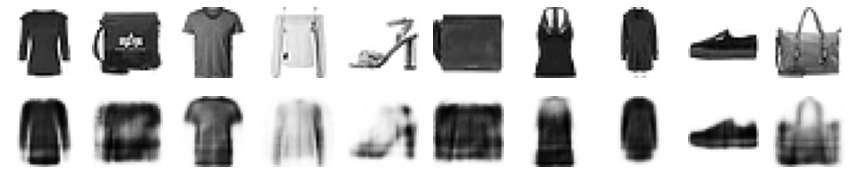

In [22]:
show_reconstructions(stacked_ae_1_by_1)

In [23]:
keras.backend.clear_session()

conv_encoder = keras.models.Sequential([ 
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, 3, padding="same", activation="selu"),
    keras.layers.MaxPooling2D(2),    
    keras.layers.Conv2D(32, 3, padding="same", activation="selu"),
    keras.layers.MaxPooling2D(2),    
    keras.layers.Conv2D(64, 3, padding="same", activation="selu"),
    keras.layers.MaxPooling2D(2),    
])

conv_decoder = keras.models.Sequential([ 
    keras.layers.Conv2DTranspose(32, 3, strides=2, padding="valid", activation="selu", input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="selu"),
    keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same", activation="sigmoid"),
    keras.layers.Reshape([28, 28]),
])

conv_auotoencoder = keras.models.Sequential([conv_encoder, conv_decoder])

conv_auotoencoder.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

conv_auotoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 21s 8ms/step - loss: 0.3018 - rounded_accuracy: 0.9188 - val_loss: 0.2793 - val_rounded_accuracy: 0.9401
Epoch 2/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.2758 - rounded_accuracy: 0.9413 - val_loss: 0.2740 - val_rounded_accuracy: 0.9457
Epoch 3/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2711 - rounded_accuracy: 0.9461 - val_loss: 0.2726 - val_rounded_accuracy: 0.9457
Epoch 4/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2685 - rounded_accuracy: 0.9487 - val_loss: 0.2682 - val_rounded_accuracy: 0.9513
Epoch 5/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2667 - rounded_accuracy: 0.9507 - val_loss: 0.2667 - val_rounded_accuracy: 0.9525
Epoch 6/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2655 - rounded_accuracy: 0.9521 - val_loss: 0.2664 - val_rounded_accuracy: 0.9523
Epoch 7/10
1719/1719 [============

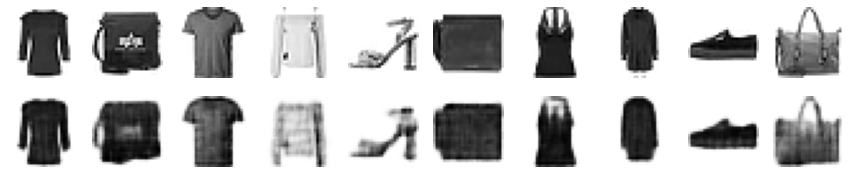

In [24]:
show_reconstructions(conv_auotoencoder)

In [25]:
keras.backend.clear_session()

recurrent_encoder = keras.models.Sequential([ 
    keras.layers.LSTM(100, return_sequences=True, input_shape=[None, 28]),
    keras.layers.LSTM(30),
])

recurrent_decoder = keras.models.Sequential([ 
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid")),
])

recurrent_autoencoder = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

recurrent_autoencoder.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.1), metrics=[rounded_accuracy])

recurrent_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 37s 18ms/step - loss: 0.5037 - rounded_accuracy: 0.7613 - val_loss: 0.4341 - val_rounded_accuracy: 0.8251
Epoch 2/10
1719/1719 [==============================] - 29s 17ms/step - loss: 0.3942 - rounded_accuracy: 0.8481 - val_loss: 0.3715 - val_rounded_accuracy: 0.8660
Epoch 3/10
1719/1719 [==============================] - 29s 17ms/step - loss: 0.3596 - rounded_accuracy: 0.8757 - val_loss: 0.3526 - val_rounded_accuracy: 0.8789
Epoch 4/10
1719/1719 [==============================] - 29s 17ms/step - loss: 0.3449 - rounded_accuracy: 0.8851 - val_loss: 0.3406 - val_rounded_accuracy: 0.8879
Epoch 5/10
1719/1719 [==============================] - 29s 17ms/step - loss: 0.3360 - rounded_accuracy: 0.8904 - val_loss: 0.3354 - val_rounded_accuracy: 0.8930
Epoch 6/10
1719/1719 [==============================] - 29s 17ms/step - loss: 0.3299 - rounded_accuracy: 0.8946 - val_loss: 0.3270 - val_rounded_accuracy: 0.8983
Epoch 7/10
1719/1719 [======

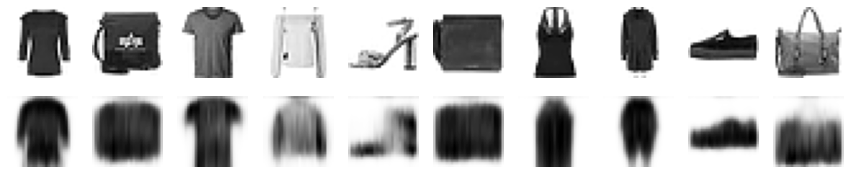

In [26]:
show_reconstructions(recurrent_autoencoder)

In [27]:
keras.backend.clear_session()

denoising_encoder = keras.models.Sequential([ 
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])

denoising_decoder = keras.models.Sequential([ 
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28]),
])

denoising_autoencoder = keras.models.Sequential([denoising_encoder, denoising_decoder])

denoising_autoencoder.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

denoising_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3510 - rounded_accuracy: 0.8772 - val_loss: 0.3216 - val_rounded_accuracy: 0.9060
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3125 - rounded_accuracy: 0.9093 - val_loss: 0.3077 - val_rounded_accuracy: 0.9156
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3061 - rounded_accuracy: 0.9148 - val_loss: 0.3045 - val_rounded_accuracy: 0.9151
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3027 - rounded_accuracy: 0.9178 - val_loss: 0.3007 - val_rounded_accuracy: 0.9198
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2998 - rounded_accuracy: 0.9203 - val_loss: 0.2977 - val_rounded_accuracy: 0.9245
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2979 - rounded_accuracy: 0.9219 - val_loss: 0.2961 - val_rounded_accuracy: 0.9256
Epoch 7/10
1719/1719 [============

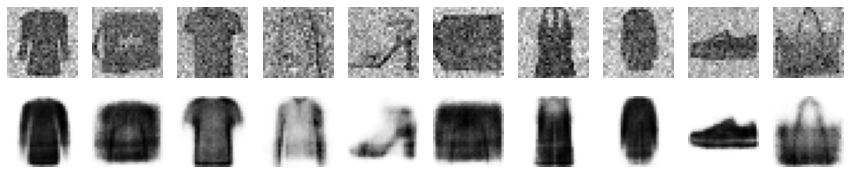

In [28]:
noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_autoencoder, noise(X_valid, training=True))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3570 - rounded_accuracy: 0.8705 - val_loss: 0.3219 - val_rounded_accuracy: 0.8992
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3201 - rounded_accuracy: 0.9014 - val_loss: 0.3133 - val_rounded_accuracy: 0.9096
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3145 - rounded_accuracy: 0.9060 - val_loss: 0.3103 - val_rounded_accuracy: 0.9095
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3110 - rounded_accuracy: 0.9088 - val_loss: 0.3068 - val_rounded_accuracy: 0.9152
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3085 - rounded_accuracy: 0.9107 - val_loss: 0.3049 - val_rounded_accuracy: 0.9148
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3067 - rounded_accuracy: 0.9121 - val_loss: 0.3032 - val_rounded_accuracy: 0.9166
Epoch 7/10
1719/1719 [============

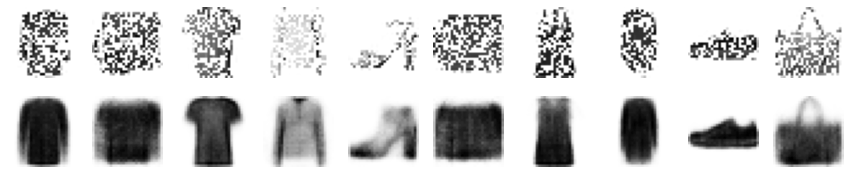

In [29]:
keras.backend.clear_session()

dropout_encoder = keras.models.Sequential([ 
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])

dropout_decoder = keras.models.Sequential([ 
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28]),
])

dropout_autoencoder = keras.models.Sequential([dropout_encoder, dropout_decoder])

dropout_autoencoder.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

dropout_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_autoencoder, dropout(X_valid, training=True))

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4334 - rounded_accuracy: 0.7962 - val_loss: 0.3790 - val_rounded_accuracy: 0.8504
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3644 - rounded_accuracy: 0.8645 - val_loss: 0.3544 - val_rounded_accuracy: 0.8755
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3448 - rounded_accuracy: 0.8822 - val_loss: 0.3421 - val_rounded_accuracy: 0.8858
Epoch 4/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3332 - rounded_accuracy: 0.8922 - val_loss: 0.3292 - val_rounded_accuracy: 0.8964
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3241 - rounded_accuracy: 0.8990 - val_loss: 0.3276 - val_rounded_accuracy: 0.9013
Epoch 6/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3203 - rounded_accuracy: 0.9016 - val_loss: 0.3250 - val_rounded_accuracy: 0.9005
Epoch 7/10
1719/1719 [============

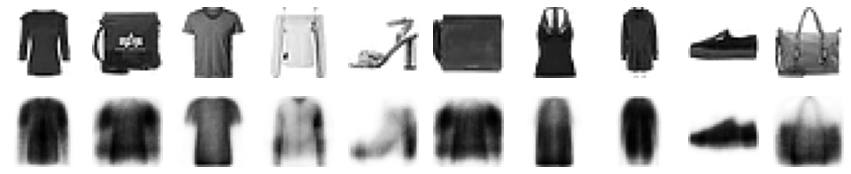

In [30]:
simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])

simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

simple_autoencoder = keras.models.Sequential([simple_encoder, simple_decoder])

simple_autoencoder.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.), metrics=[rounded_accuracy])

simple_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

show_reconstructions(simple_autoencoder)

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4285 - rounded_accuracy: 0.8175 - val_loss: 0.3794 - val_rounded_accuracy: 0.8622
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3678 - rounded_accuracy: 0.8705 - val_loss: 0.3608 - val_rounded_accuracy: 0.8773
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3520 - rounded_accuracy: 0.8831 - val_loss: 0.3489 - val_rounded_accuracy: 0.8854
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3427 - rounded_accuracy: 0.8891 - val_loss: 0.3441 - val_rounded_accuracy: 0.8919
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3356 - rounded_accuracy: 0.8943 - val_loss: 0.3350 - val_rounded_accuracy: 0.8982
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3295 - rounded_accuracy: 0.8993 - val_loss: 0.3294 - val_rounded_accuracy: 0.9004
Epoch 7/10
1719/1719 [============

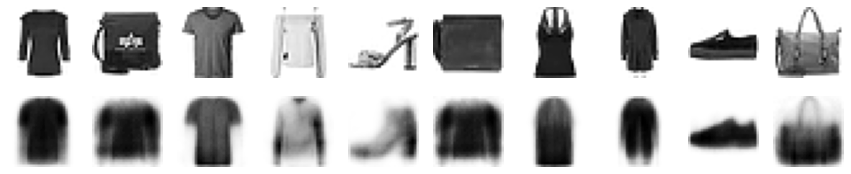

In [31]:
sparse_l1_encoder = keras.models.Sequential([ 
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3),
])

sparse_l1_decoder = keras.models.Sequential([ 
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28]),
])

sparse_l1_autoencoder = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])

sparse_l1_autoencoder.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

sparse_l1_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

show_reconstructions(sparse_l1_autoencoder)

In [50]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target

    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (kl_divergence(self.target, mean_activities) + kl_divergence(1.0-self.target, 1.0-mean_activities))

Epoch 1/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4149 - rounded_accuracy: 0.8136 - val_loss: 0.3692 - val_rounded_accuracy: 0.8624
Epoch 2/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3531 - rounded_accuracy: 0.8771 - val_loss: 0.3451 - val_rounded_accuracy: 0.8834
Epoch 3/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3353 - rounded_accuracy: 0.8906 - val_loss: 0.3309 - val_rounded_accuracy: 0.8961
Epoch 4/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.3234 - rounded_accuracy: 0.9010 - val_loss: 0.3221 - val_rounded_accuracy: 0.9034
Epoch 5/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.3180 - rounded_accuracy: 0.9053 - val_loss: 0.3182 - val_rounded_accuracy: 0.9070
Epoch 6/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.3144 - rounded_accuracy: 0.9084 - val_loss: 0.3151 - val_rounded_accuracy: 0.9081
Epoch 7/10
1719/1719 [============

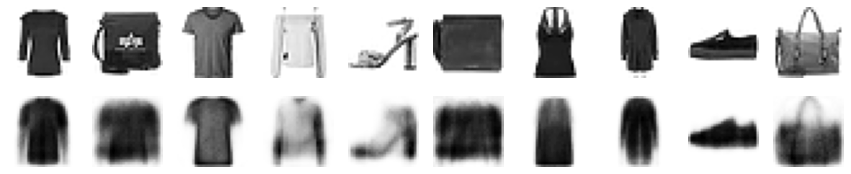

In [51]:
kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)

sparse_kl_encoder = keras.models.Sequential([ 
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg),
])

sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28]),
])

sparse_kl_autoencoder = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])

sparse_kl_autoencoder.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

sparse_kl_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

show_reconstructions(sparse_kl_autoencoder)

In [52]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var/2) + mean

In [58]:
codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [59]:
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28*28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [60]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_autoencoder = keras.Model(inputs=[inputs], outputs=[reconstructions])

Epoch 1/10
430/430 [==============================] - 7s 13ms/step - loss: 0.3882 - rounded_accuracy: 0.8629 - val_loss: 0.3536 - val_rounded_accuracy: 0.8922
Epoch 2/10
430/430 [==============================] - 6s 13ms/step - loss: 0.3428 - rounded_accuracy: 0.8977 - val_loss: 0.3429 - val_rounded_accuracy: 0.8992
Epoch 3/10
430/430 [==============================] - 6s 14ms/step - loss: 0.3327 - rounded_accuracy: 0.9050 - val_loss: 0.3339 - val_rounded_accuracy: 0.9057
Epoch 4/10
430/430 [==============================] - 7s 16ms/step - loss: 0.3274 - rounded_accuracy: 0.9091 - val_loss: 0.3275 - val_rounded_accuracy: 0.9105
Epoch 5/10
430/430 [==============================] - 6s 15ms/step - loss: 0.3241 - rounded_accuracy: 0.9119 - val_loss: 0.3218 - val_rounded_accuracy: 0.9152
Epoch 6/10
430/430 [==============================] - 6s 14ms/step - loss: 0.3217 - rounded_accuracy: 0.9138 - val_loss: 0.3228 - val_rounded_accuracy: 0.9147
Epoch 7/10
430/430 [==========================

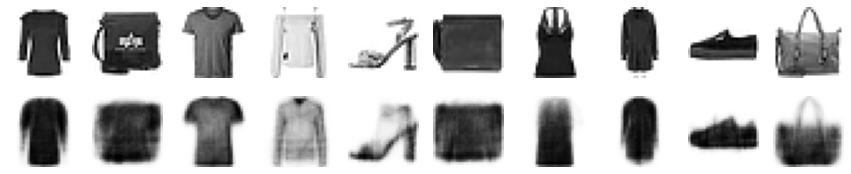

In [61]:
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
variational_autoencoder.add_loss(K.mean(latent_loss) / 784.)

variational_autoencoder.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])

variational_autoencoder.fit(X_train, X_train, epochs=10, batch_size=128, validation_data=(X_valid, X_valid))

show_reconstructions(variational_autoencoder)

In [62]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

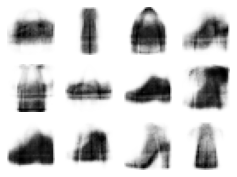

In [64]:
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

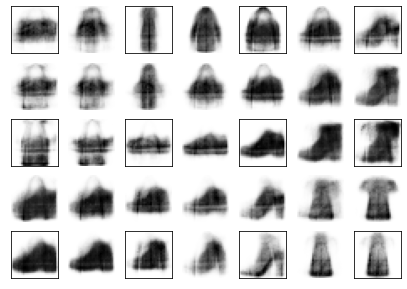

In [65]:
codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")